In [139]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold # import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score, accuracy_score
from sklearn.feature_selection import SelectFromModel

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

import yellowbrick as yb

from utilities import timeseries_train_test_split

### Predict Energy consumption

In [140]:
dataset = pd.read_csv('data1/dataset_seattle.csv')

In [141]:
dataset.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Cooling:Electricity [kW](Hourly)',
       'Date/Time', 'Electricity:Facility [kW](Hourly)',
       'Fans:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)',
       'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'InteriorEquipment:Gas [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)', 'building_type',
       'location', 'location_id', 'building_id', 'Date', 'time', 'sunriseTime',
       'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'Electricity:Facility [kW](Hourly)_lag',
       'Electricity:Facility [kW](Hourly)_future',
       'Electricity:Facility_delta_current_lag', 'Christmas Day',
       'Columbus Day', 'Independence Day', 'Labor Day',
       'Martin Luther King Day', 'Memorial Day', 'New Years Day',
       'Presidents Day', 'Thanksgiving', 'Veterans Day

In [142]:
dataset_numeric = dataset[['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility [kW](Hourly)_future',
                           'Electricity:Facility_delta_current_lag',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'location_id', 'building_id', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew',
       'USA_WA_SEATTLE']]

In [143]:
dataset_numeric.describe()

,Cooling:Electricity [kW](Hourly),Electricity:Facility [kW](Hourly),Electricity:Facility [kW](Hourly)_lag,Electricity:Facility [kW](Hourly)_future,Electricity:Facility_delta_current_lag,Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),...,RefBldgPrimarySchoolNew,RefBldgQuickServiceRestaurantNew,RefBldgSecondarySchoolNew,RefBldgSmallHotelNew,RefBldgSmallOfficeNew,RefBldgStand-aloneRetailNew,RefBldgStripMallNew,RefBldgSuperMarketNew,RefBldgWarehouseNew,USA_WA_SEATTLE
count,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,...,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.0
mean,37.778688,180.264885,180.122684,180.245595,0.142200,15.771051,103.506153,1.335365,74.133008,53.220947,...,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062350,1.0
std,101.557673,288.659340,288.534918,288.664747,395.785370,25.967284,191.686101,7.787510,169.302260,83.215305,...,0.242101,0.242101,0.242101,0.242101,0.242101,0.242101,0.242101,0.242101,0.241791,0.0
min,0.000000,1.925019,1.925019,1.925019,-1360.180141,0.000000,0.000000,0.000000,0.000000,1.011600,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,23.049338,23.041895,23.047336,-83.752714,0.252635,3.021100,0.000000,0.000000,8.092797,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,55.579849,55.575392,55.575392,12.677655,3.659254,26.929976,0.000000,6.447821,20.643869,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,8.984801,193.096680,192.900699,193.050216,96.753881,24.360913,101.032736,0.000000,67.459303,53.238744,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,458.047681,1502.776534,1502.776534,1502.776534,1359.682138,156.696697,3150.315818,219.856108,3136.861981,448.566544,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [144]:
corr_matrix = dataset_numeric.corr()
corr_matrix["Electricity:Facility [kW](Hourly)_future"].sort_values(ascending=False)

Electricity:Facility [kW](Hourly)_future      1.000000
RefBldgLargeHotelNew                          0.724359
Water Heater:WaterSystems:Gas [kW](Hourly)    0.650177
RefBldgMediumOfficeNew                        0.402842
InteriorEquipment:Gas [kW](Hourly)            0.276767
Electricity:Facility [kW](Hourly)_lag         0.244781
Heating:Electricity [kW](Hourly)              0.161458
Gas:Facility [kW](Hourly)                     0.144028
InteriorEquipment:Electricity [kW](Hourly)    0.098185
RefBldgSmallHotelNew                          0.080537
RefBldgLargeOfficeNew                         0.072545
InteriorLights:Electricity [kW](Hourly)       0.065154
Electricity:Facility [kW](Hourly)             0.059379
Fans:Electricity [kW](Hourly)                 0.038090
is_weekend                                    0.035386
temperatureHigh                               0.028246
Monday                                        0.026009
Sunday                                        0.024994
Tuesday   

In [145]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
dataset_numeric_scaling = dataset_numeric[['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility [kW](Hourly)_future',
                           'Electricity:Facility_delta_current_lag',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover']]
scaled_df = scaler.fit_transform(dataset_numeric_scaling)
scaled_df = pd.DataFrame(scaled_df, columns=['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility [kW](Hourly)_future',
                           'Electricity:Facility_delta_current_lag',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover'])

one_hot_encoded_data = dataset_numeric[['Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew',
       'USA_WA_SEATTLE']]

In [146]:
processed_data = pd.concat((scaled_df, one_hot_encoded_data), axis=1)

In [147]:
processed_data.columns

Index(['Cooling:Electricity [kW](Hourly)', 'Electricity:Facility [kW](Hourly)',
       'Electricity:Facility [kW](Hourly)_lag',
       'Electricity:Facility [kW](Hourly)_future',
       'Electricity:Facility_delta_current_lag',
       'Fans:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)',
       'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'InteriorEquipment:Gas [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
       'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
       'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
       'Presidents Day', 'Thanksgiving', 'Veterans Day', 'is_weekend',
       'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', '

In [148]:
dataset_features = processed_data[['Cooling:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                            'InteriorEquipment:Electricity [kW](Hourly)',
                            'Fans:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility_delta_current_lag',
                           'Heating:Electricity [kW](Hourly)',
                            'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew',
       'USA_WA_SEATTLE',
        'time', 'sunriseTime', 'sunsetTime']]

dataset_labels = processed_data['Electricity:Facility [kW](Hourly)_future']

In [149]:
#X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.2)
X_train, X_test, y_train, y_test = timeseries_train_test_split(dataset_features, dataset_labels, test_size=0.2)

Linear Regression model
Mean Squared Error: 0.160
Coefficient of Determination: 0.841
Coefficients: [ 1.13027755e-01  3.30365281e-02  1.31206004e-01 -1.65886337e-02
  5.70879962e+09 -5.70633894e+09 -7.82742514e+09  2.71477227e-02
  4.18894811e-02  8.64772085e-02 -6.50396148e-03  1.32185315e-02
 -5.55847259e-03 -3.91758642e-03 -2.24578700e-03 -1.44864389e-01
  3.10472795e-03 -1.68712246e-01  3.75642291e-02  1.24350513e-02
  5.27151291e-02  1.24798368e-02  2.89275985e-02  3.82024000e-03
 -3.24803811e-03  3.46211138e+10 -1.93728432e-02  3.62496030e+10
  3.62496030e+10  1.62848916e+09  1.62848916e+09  3.62496030e+10
  3.62496030e+10  3.62496030e+10  1.11687921e+11  1.11687921e+11
  1.11687921e+11  1.11687921e+11  1.11687921e+11  1.11687921e+11
  1.11687921e+11  1.11687921e+11  1.11687921e+11  1.11687921e+11
  1.11687921e+11  1.11687921e+11  1.11687921e+11  1.11687921e+11
  1.11687921e+11  1.11687921e+11  0.00000000e+00 -7.69245463e+01
  3.53837218e+01  4.15443663e+01]


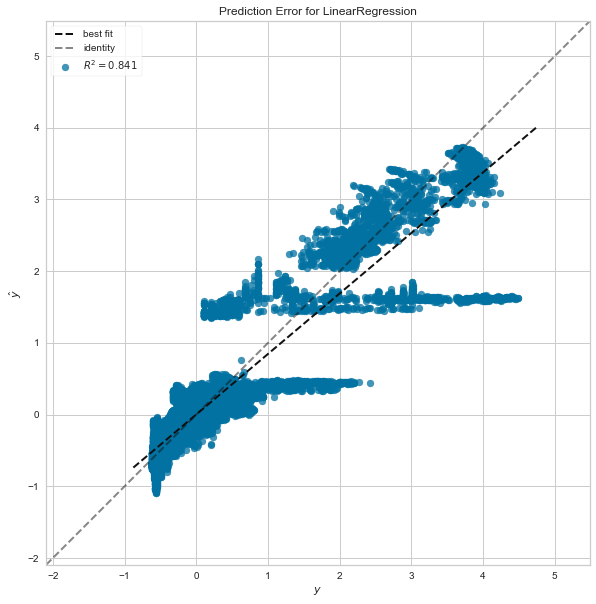

In [150]:
X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.2)
from yellowbrick.regressor import PredictionError
model = LinearRegression(normalize=True)
est = model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Linear Regression model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))
print('Coefficients: {}'.format(model.coef_))
visualizer = PredictionError(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Ridge model
Mean Squared Error: 0.178
Coefficient of Determination: 0.823


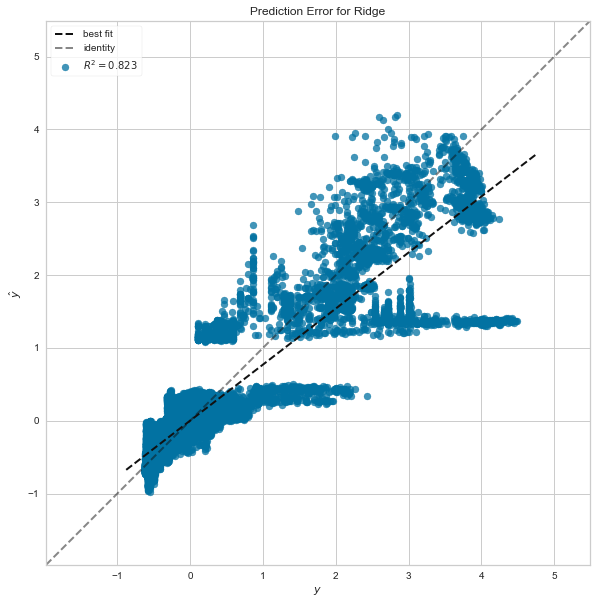

In [151]:
# X_train, X_test, y_train, y_test = timeseries_train_test_split(dataset_features, dataset_labels, test_size=0.2)
ridge = Ridge(alpha=1000)
ridge.fit(X_train, y_train)

expected = y_test
predicted = ridge.predict(X_test)

print('Ridge model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(ridge, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()         

Ridge model
Mean squared error = 0.160
R2 score = 0.841


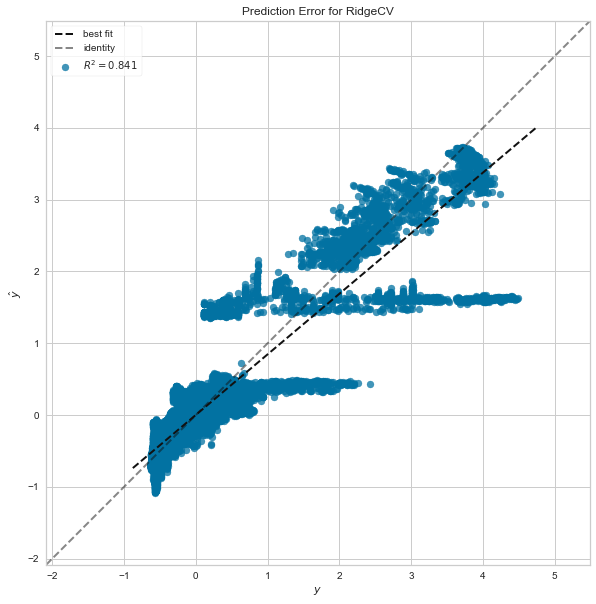

In [152]:
regr_cv = RidgeCV(alphas=[0.5, 100, 1000])
regr_cv.fit(X_train, y_train)

expected = y_test
predicted = regr_cv.predict(X_test)

print('Ridge model')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(regr_cv, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()

In [153]:
regr_trans = TransformedTargetRegressor(regressor=RidgeCV(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)
regr_trans.fit(X_train, y_train)
expected = y_test
predicted = regr_trans.predict(X_test)

print('Transformed target regressor')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Transformed target regressor
Mean squared error = 0.166
R2 score = 0.835


Gradient boosting regressor
Mean squared error = 0.164
R2 score = 0.837


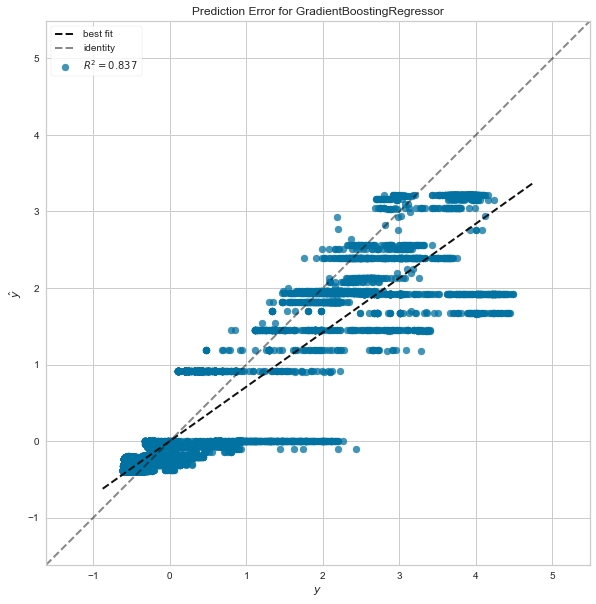

In [154]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=50, max_depth=2, learning_rate=0.05)
gb.fit(X_train,y_train)
expected = y_test
predicted = gb.predict(X_test)

print('Gradient boosting regressor')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(gb, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Lasso
Mean squared error = 0.616
R2 score = 0.387


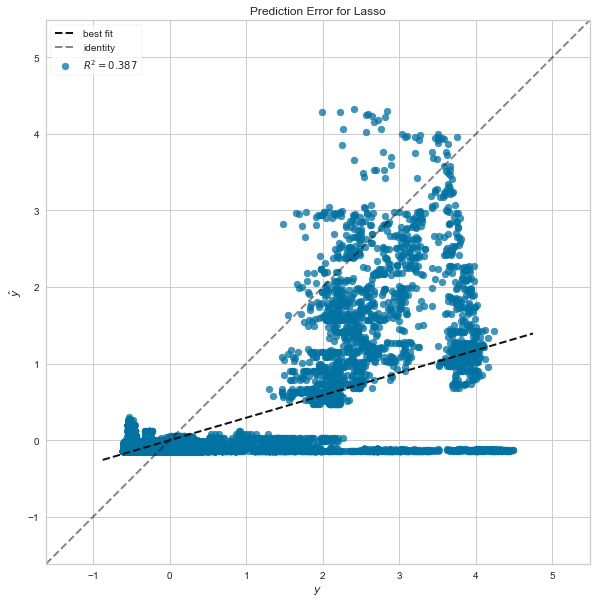

In [155]:
lasso = Lasso(alpha=0.2, max_iter=10e5)
lasso.fit(X_train,y_train)
expected = y_test
predicted = lasso.predict(X_test)

print('Lasso')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(lasso, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [156]:
elastic = ElasticNet(alpha=0.15, max_iter=10e5)
elastic.fit(X_train,y_train)
expected = y_test
predicted = elastic.predict(X_test)

print('Elastic')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Elastic
Mean squared error = 0.520
R2 score = 0.483


knn
Mean squared error = 0.031
R2 score = 0.969


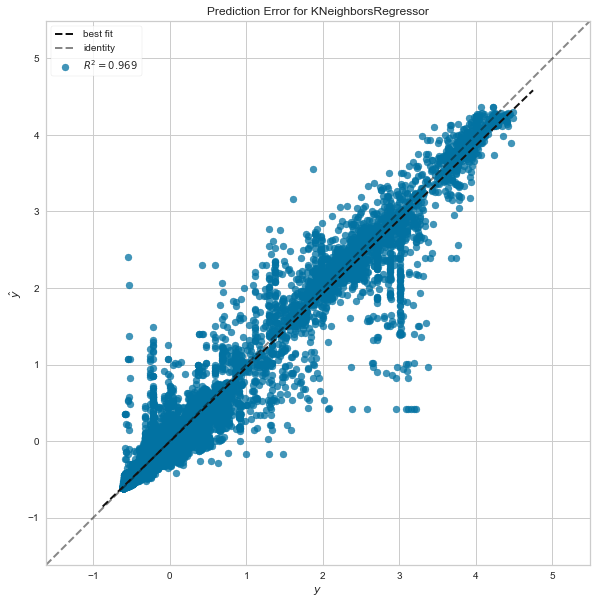

In [157]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(X_train,y_train)
expected = y_test
predicted = knn.predict(X_test)

print('knn')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(knn, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Random Forest Regressor
Mean squared error = 0.132
R2 score = 0.868


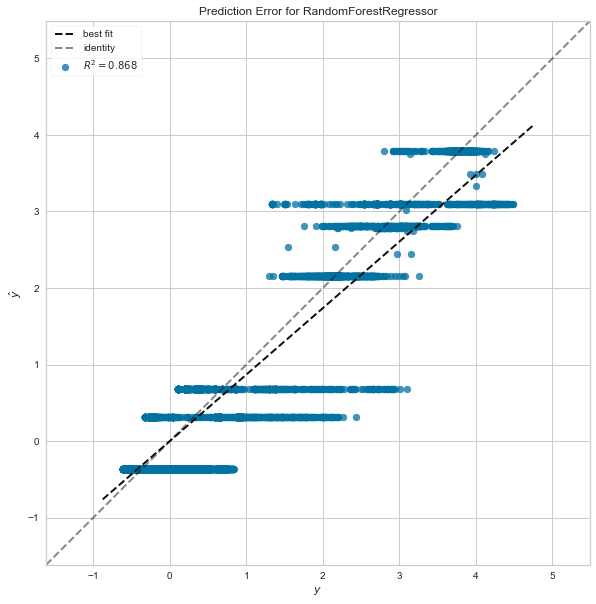

In [158]:
random_forest = RandomForestRegressor(n_estimators=50, max_depth=3)
random_forest.fit(X_train,y_train)
expected = y_test
predicted = random_forest.predict(X_test)

print('Random Forest Regressor')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(random_forest, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

## Feature Analysis and Selection

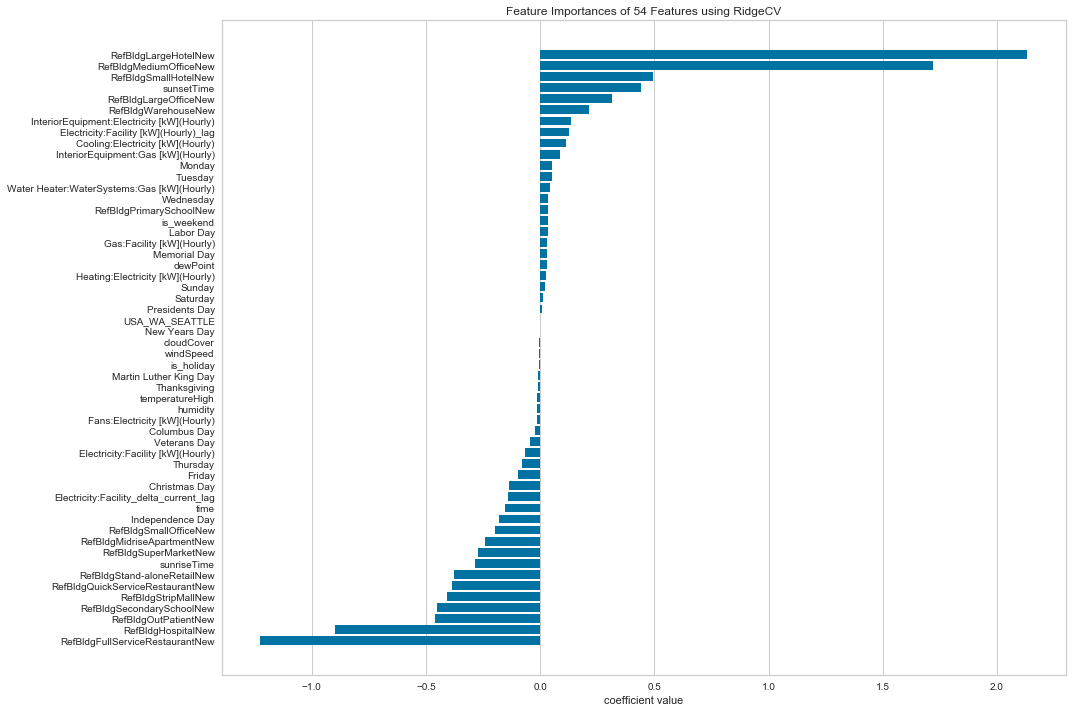

In [159]:
from yellowbrick.features import FeatureImportances

# model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(regr_cv, size=(1080, 720), relative=False)

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

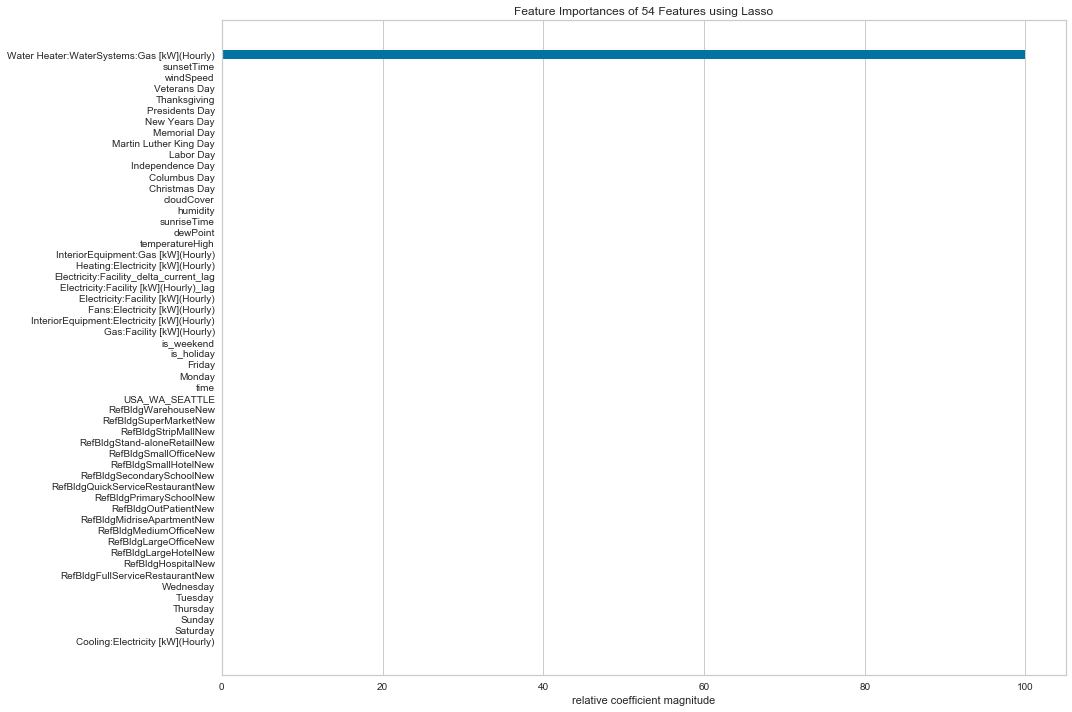

In [160]:
viz = FeatureImportances(lasso, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

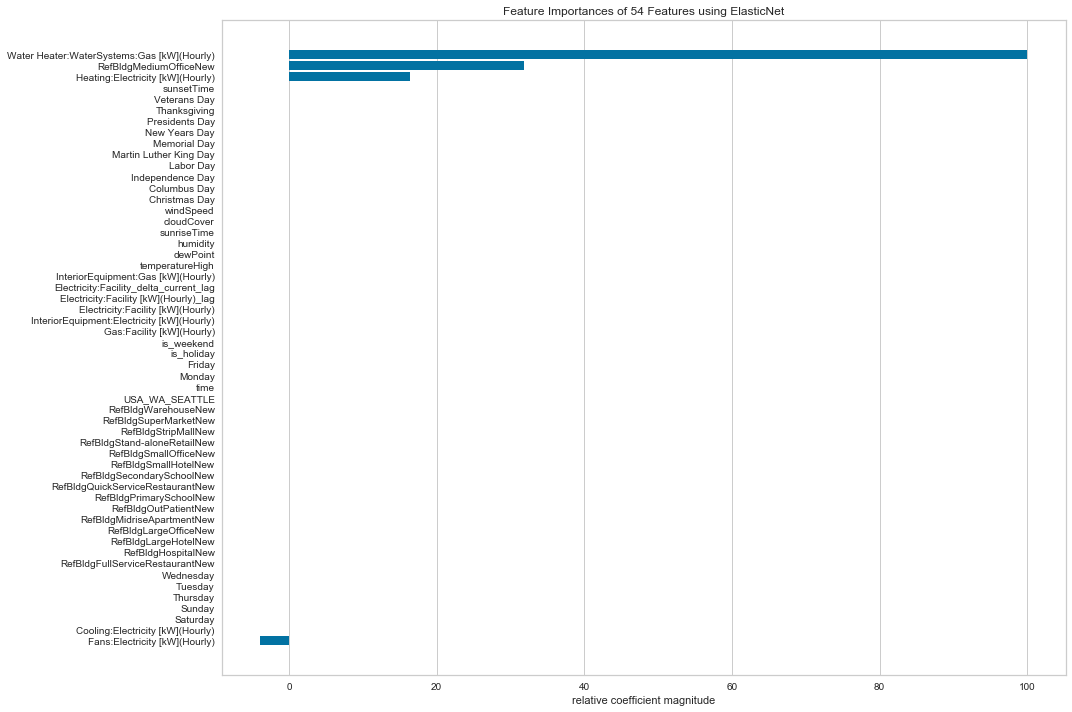

In [161]:
viz = FeatureImportances(elastic, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

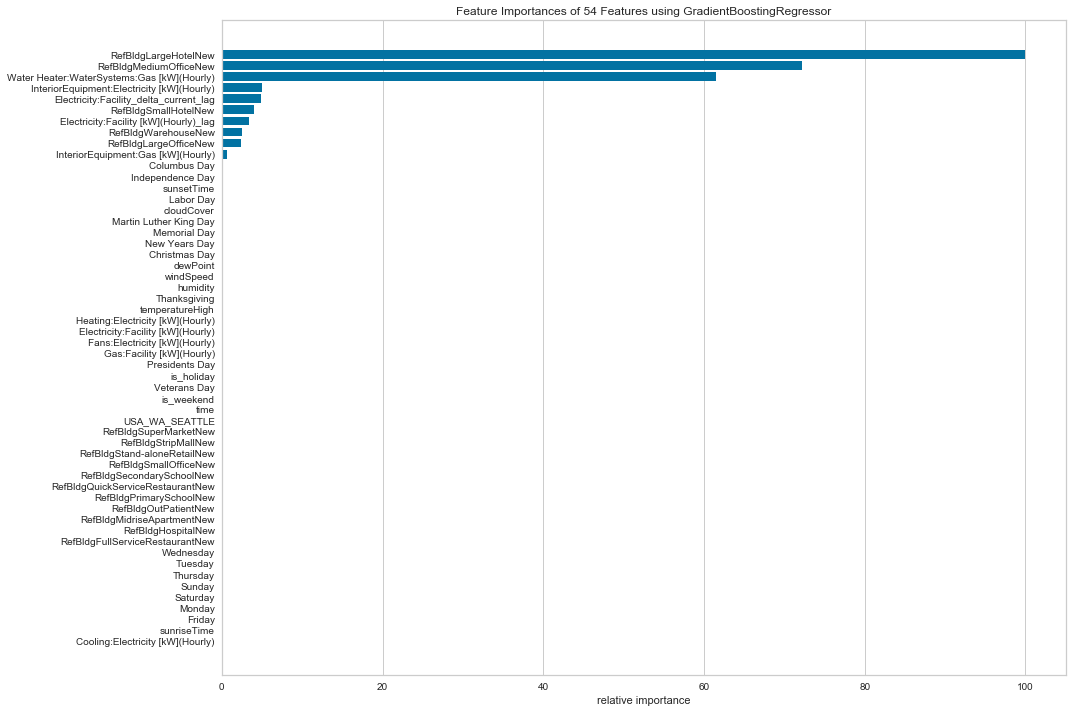

In [162]:
viz = FeatureImportances(gb, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

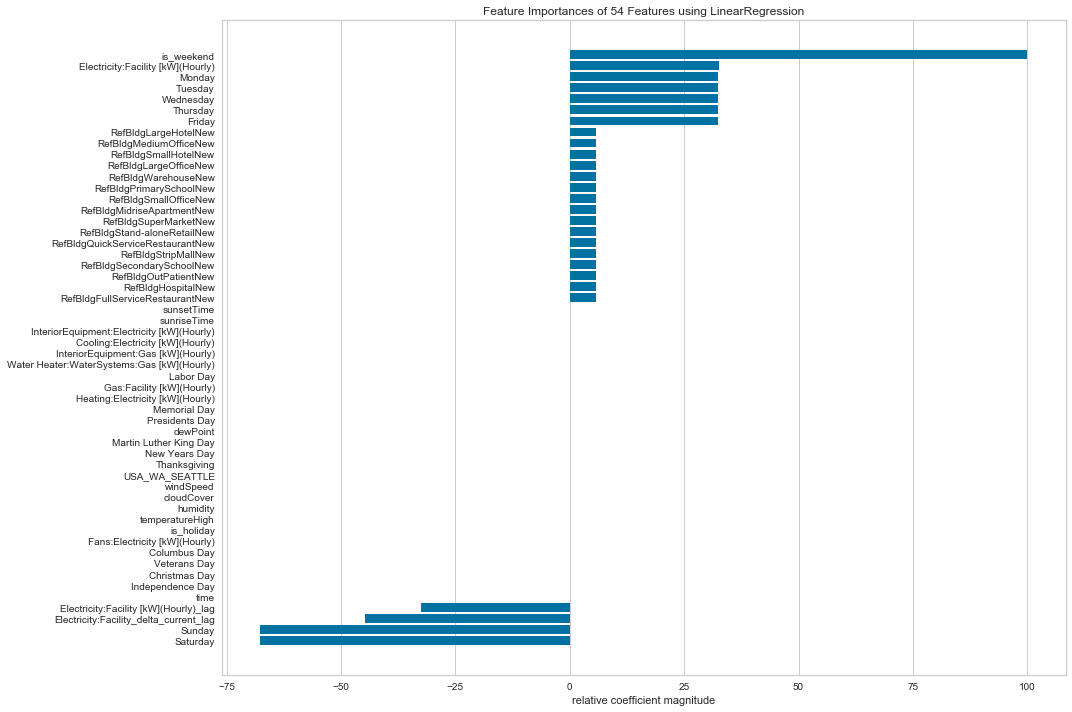

In [163]:
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

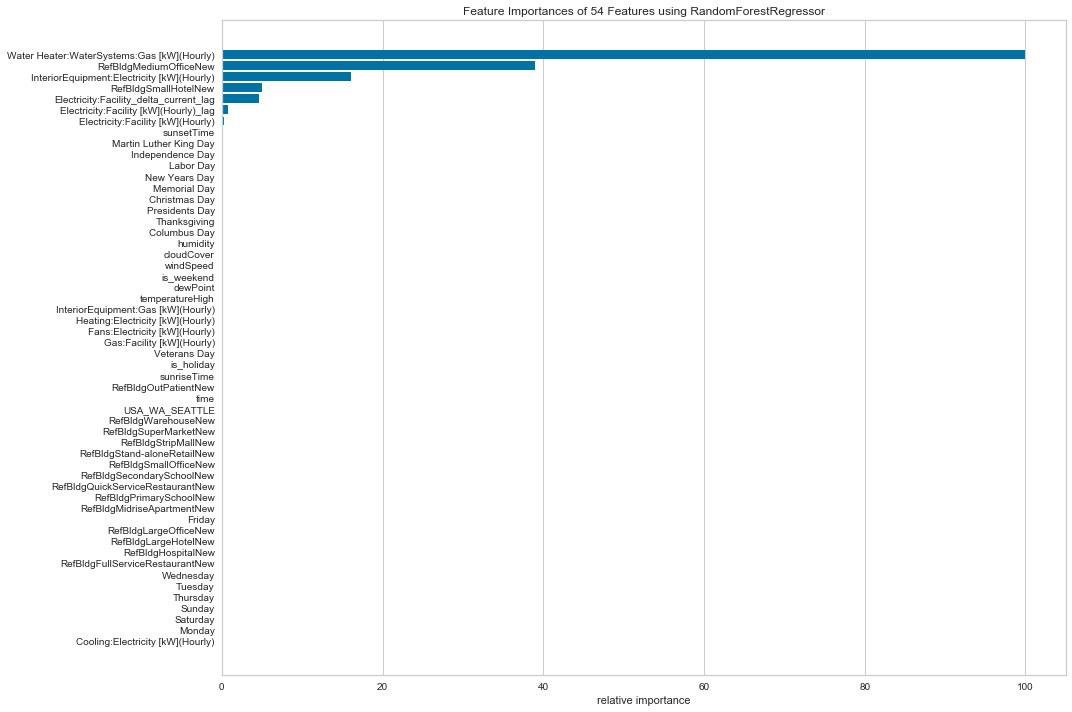

In [164]:
viz = FeatureImportances(random_forest, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

## Residual plots

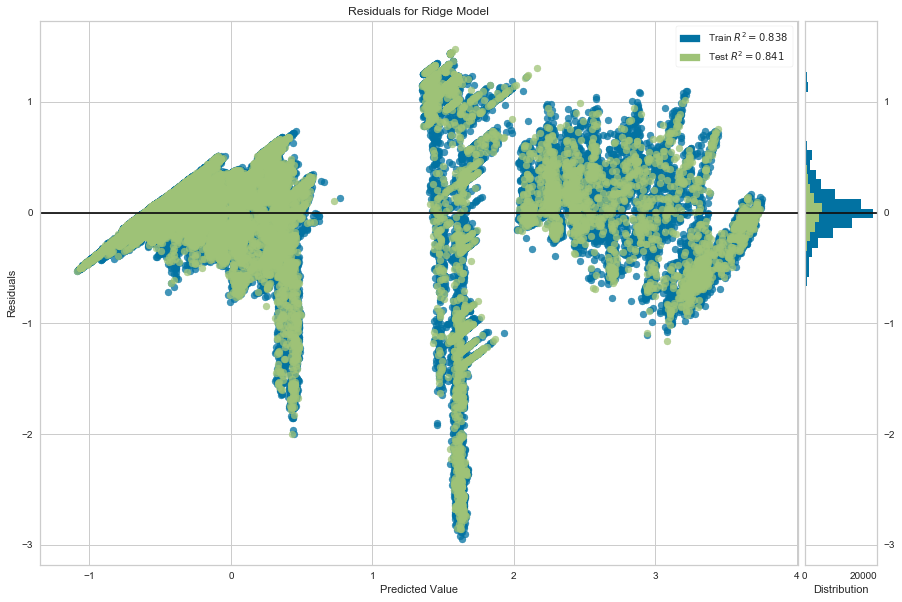

In [165]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = Ridge()
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

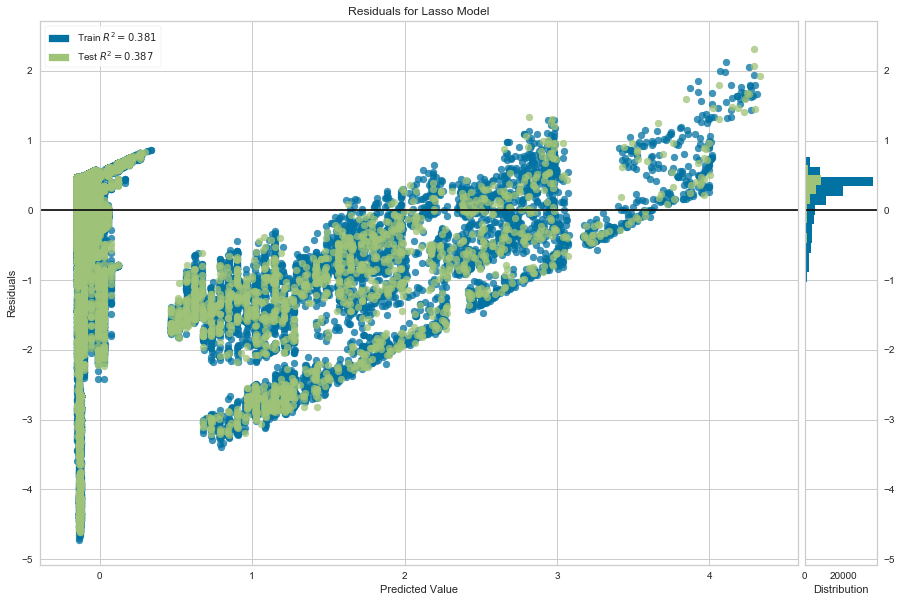

In [166]:
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = Lasso(alpha=0.2, max_iter=10e5)
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

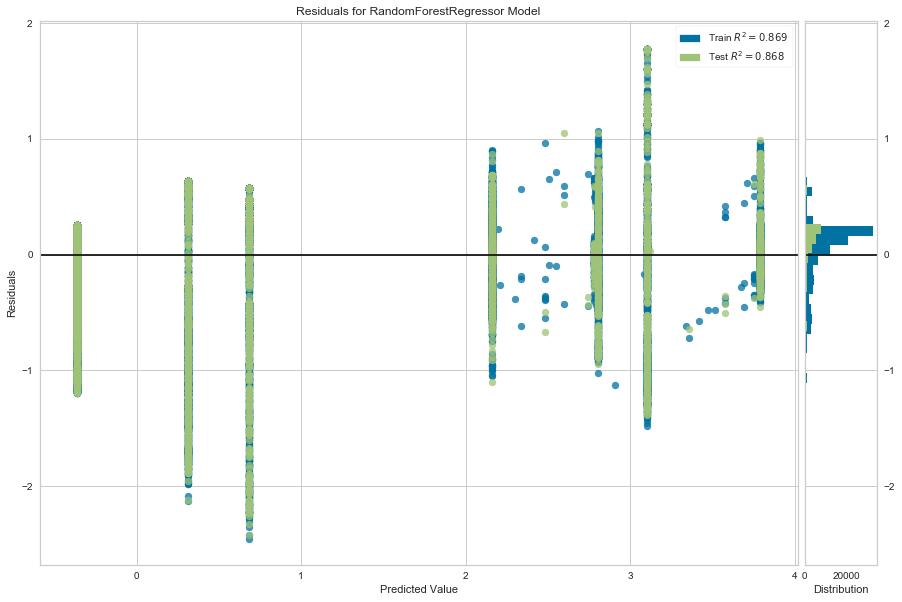

In [167]:
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = RandomForestRegressor(n_estimators=50, max_depth=3)
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

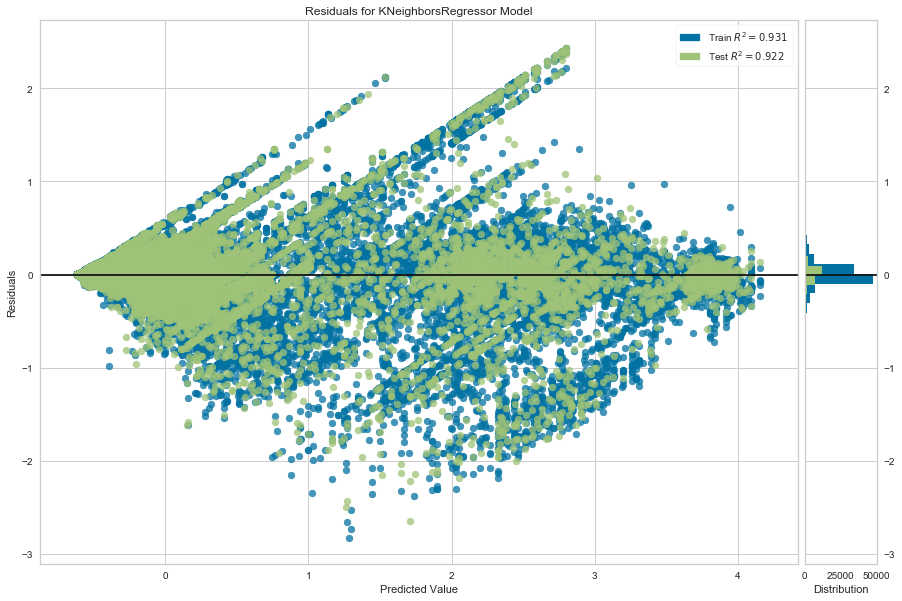

In [171]:
from sklearn.neighbors import KNeighborsRegressor

from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = KNeighborsRegressor(n_neighbors=15)
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

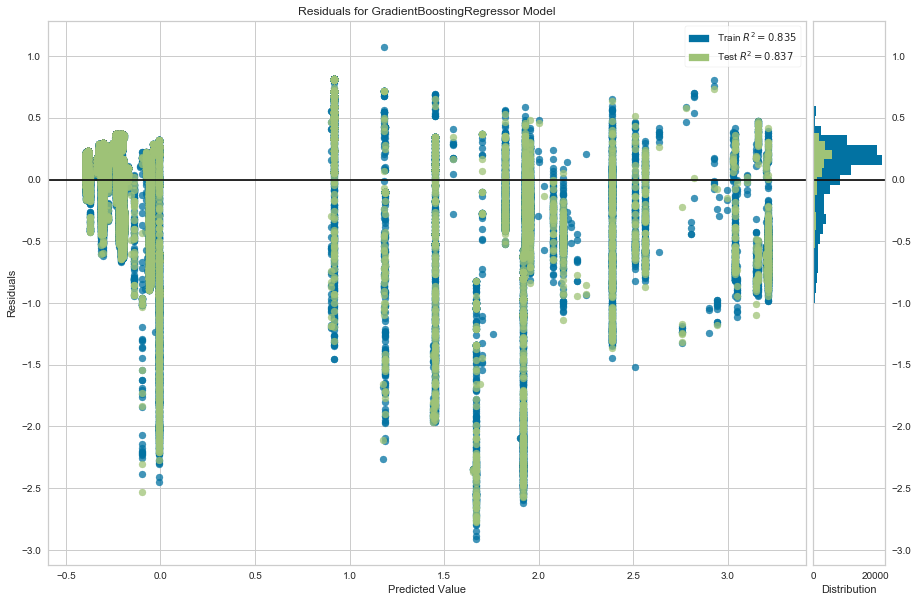

In [169]:
from sklearn.ensemble import GradientBoostingRegressor

from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
gb = GradientBoostingRegressor(n_estimators=50, max_depth=2, learning_rate=0.05)
visualizer = ResidualsPlot(gb, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data